In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper function

In [ ]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

#Gradient and Hessian of elastic energies

In [ ]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [ ]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [ ]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [ ]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

# Functions to create elastic force vector and its Hessian

In [ ]:
def getFs(q, EA, deltaL):
  # q - DOF vector of size N
  # EA - stretching stiffness
  # deltaL - undeformed reference length (assume to be a scalar for this simple example)
  # Output:
  # Fs - a vector (negative gradient of elastic stretching force)
  # Js - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fs = np.zeros(ndof) # stretching force
  Js = np.zeros((ndof, ndof))

  for k in range(0, N-1):
      # May need to modify if network of beams
      # k-th stretching spring (USE A LOOP for the general case
      xkm1 = q[2*k] # x coordinate of the first node
      ykm1 = q[2*k+1] # y coordinate of the first node
      xk = q[2*k+2] # x coordinate of the second node
      yk = q[2*k+3] # y coordinate of the second node
      ind = np.arange(2*k, 2*k+4) # 0, 1, 2, 3 for k = 0
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)

      Fs[ind] -= gradEnergy # force = - gradient of energy. Fs is the stretching force
      Js[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:4

  return Fs, Js

In [ ]:
def getFb(q, EI, deltaL, t, kappa_amp, omega, k_wave):
    ndof = q.size
    N = ndof // 2

    Fb = np.zeros(ndof)
    Jb = np.zeros((ndof, ndof))

    RodLength = deltaL * (N - 1)

    for k in range(1, N-1):

        xkm1 = q[2*k-2]
        ykm1 = q[2*k-1]
        xk   = q[2*k]
        yk   = q[2*k+1]
        xkp1 = q[2*k+2]
        ykp1 = q[2*k+3]

        # Arc location & normalized coordinate
        s_k = k * deltaL
        xi = s_k / RodLength       # 0 at base, 1 at tip

        # --- 1) Curvature envelope (already there) ---
        envelope = xi**2           # or xi if you want milder growth
        curvature0 = kappa_amp * envelope * np.sin(omega * t - k_wave * s_k)

        # --- 2) Position-dependent bending stiffness (tip stiffer) ---
        stiff_factor = 1.0 + 4.0 * xi**2   # base: 1×EI, tip: ~5×EI
        EI_eff = EI * stiff_factor

        ind = np.arange(2*k-2, 2*k+4)

        gradEnergy = gradEb(
            xkm1, ykm1,
            xk,   yk,
            xkp1, ykp1,
            curvature0, deltaL, EI_eff   # <-- use EI_eff
        )

        hessEnergy = hessEb(
            xkm1, ykm1,
            xk,   yk,
            xkp1, ykp1,
            curvature0, deltaL, EI_eff   # <-- use EI_eff
        )

        Fb[ind] -= gradEnergy
        Jb[np.ix_(ind, ind)] -= hessEnergy

    return Fb, Jb


# Objective Function or Integrator

Given the old position and the old velocity, find out th new position and the new velocity

In [ ]:
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat,          # inertia
           EI, EA,           # elastic stiffness
           W, C,             # external forces / damping
           deltaL,
           free_index,
           t,                # current time
           kappa_amp, omega, k_wave):

    q_new = q_old.copy()     # Newton initial guess

    iter_count = 0
    error = tol * 10.0
    flag = 1                 # 1 = success, -1 = failure

    while error > tol:
        # Inertia
        F_inertia = m/dt * ((q_new - q_old) / dt - u_old)
        J_inertia = mMat / dt**2

        # Elastic forces: stretching + bending
        Fs, Js = getFs(q_new, EA, deltaL)
        Fb, Jb = getFb(q_new, EI, deltaL, t, kappa_amp, omega, k_wave)
        F_elastic = Fs + Fb
        J_elastic = Js + Jb

        # Viscous (linear) drag
        Fv = - C @ ((q_new - q_old) / dt)
        Jv = - C / dt

        # Residual and Jacobian of equations of motion
        f = F_inertia - F_elastic - Fv - W
        J = J_inertia - J_elastic - Jv

        # Restrict to free DOFs
        f_free = f[free_index]
        J_free = J[np.ix_(free_index, free_index)]

        # Newton step
        dq_free = np.linalg.solve(J_free, f_free)
        q_new[free_index] -= dq_free

        # Convergence check
        error = np.linalg.norm(f_free)
        iter_count += 1
        if iter_count > maximum_iter:
            flag = -1
            print("Maximum number of iterations reached in objfun.")
            return q_new, flag

    return q_new, flag


# Main

In [ ]:
# Main simulation parameters
nv = 9  # number of nodes/vertices (odd for unique middle)
ndof = 2 * nv
midNode = (nv + 1) // 2  # middle node index

# Time step
dt = 1  # second

# Rod parameters from assignment
RodLength = 1.0  # meter
R_outer = 0.013  # meter (outer radius)
R_inner = 0.011  # meter (inner radius)
rho_metal = 2700  # kg/m^3 (aluminum)
Y = 70e9  # 70 GPa

# Cross sectional area and moment
A = np.pi * (R_outer**2 - R_inner**2)
I_moment = np.pi/4 * (R_outer**4 - R_inner**4)

# Discrete length / reference length
deltaL = RodLength / (nv - 1)

# Elastic modulus calculations
EI = Y * I_moment
EA = Y * A

# Maximum number of iterations
maximum_iter = 1000

# Total time
totalTime = 1000  # seconds (reduced for testing)

# Variables related to plotting
saveImage = 0
plotStep = 100  # Plot every 100 steps

# Utility quantities
ne = nv - 1  # number of edges

# Tolerance
tol = EI / RodLength ** 2 * 1e-3

# Geometry - initial straight beam
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * deltaL  # x-coordinate
    nodes[c, 1] = 0.0  # y-coordinate

# Mass vector and matrix - uniform distribution
m = np.zeros(2 * nv)
node_mass = rho_metal * A * deltaL  # mass per node
for k in range(nv):
    m[2*k] = node_mass  # mass along x
    m[2*k+1] = node_mass  # mass along y
mMat = np.diag(m)

# Gravity (external force)
W = np.zeros(2 * nv)
g = np.array([0, -9.81])  # m/s^2
for k in range(nv):
    W[2*k] = node_mass * g[0]  # Weight along x
    W[2*k+1] = node_mass * g[1]  # Weight along y

# Viscous damping (external force)
visc = 0.0  # Pa-s (reduced for stability)
C = np.zeros((2 * nv, 2 * nv))
for k in range(nv):
    # Use equivalent sphere radius for damping calculation
    equiv_radius = np.sqrt(A/np.pi)  # approximate radius for damping
    C[2*k, 2*k] = 6.0 * np.pi * visc * equiv_radius  # Damping along x
    C[2*k+1, 2*k+1] = 6.0 * np.pi * visc * equiv_radius  # Damping along y

# Initial conditions
q0 = np.zeros(2 * nv)
for c in range(nv):
    q0[2*c] = nodes[c, 0]  # x coordinate
    q0[2*c+1] = nodes[c, 1]  # y coordinate

u0 = np.zeros(2 * nv)  # old velocity

# Boundary conditions setup
all_DOFs = np.arange(ndof)
# Left end is clamped at origin (nodes 0)
fixed_left = np.array([0, 1])  # x0, y0 fixed at (0,0)

# Initialize control variables
xc, yc, theta_c = RodLength, 0.0, 0.0  # initial control values
x_curr_prev = q0[2*(midNode-1)]  # initial middle node x
y_curr_prev = q0[2*(midNode-1)+1]  # initial middle node y

Starting curvature-driven tail simulation...


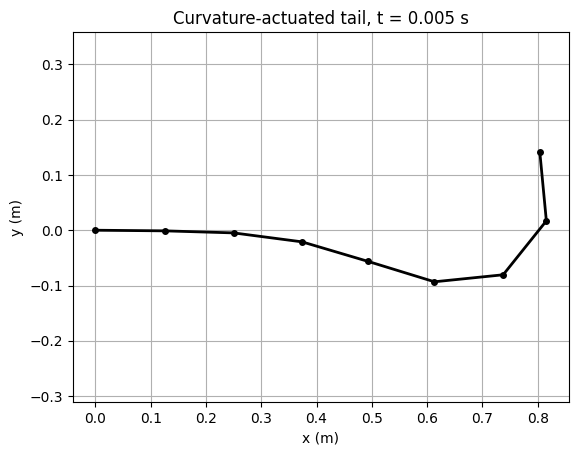

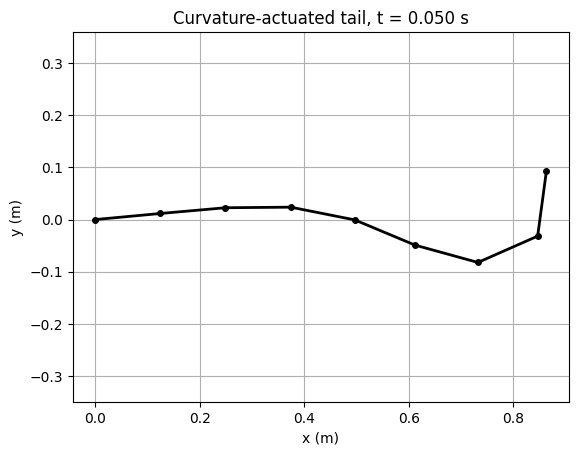

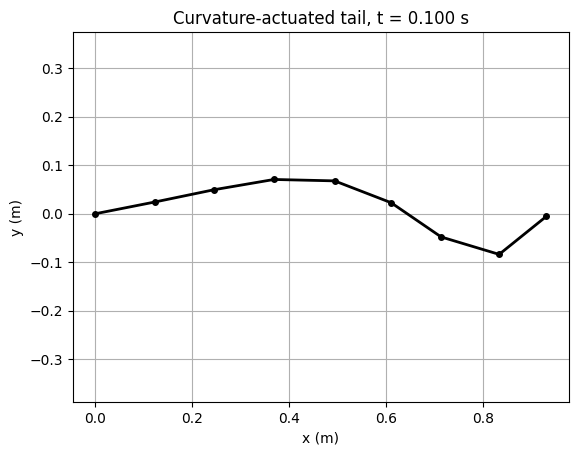

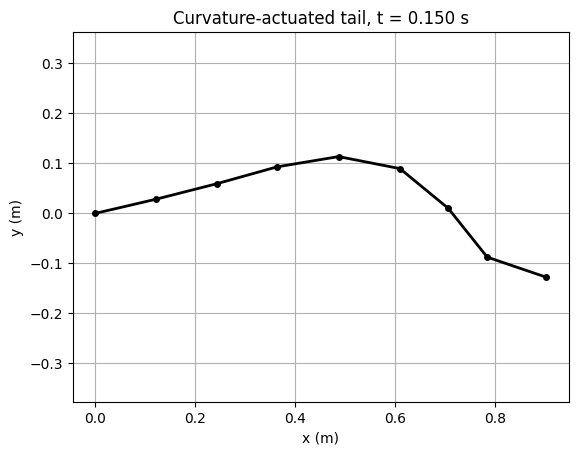

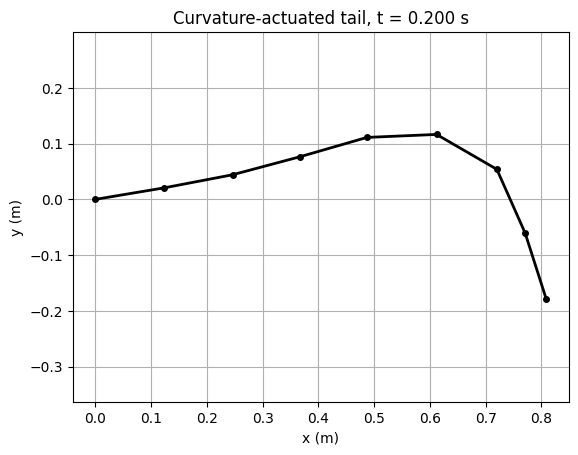

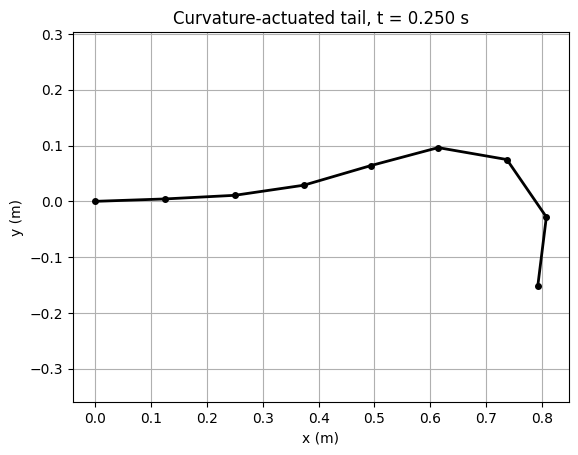

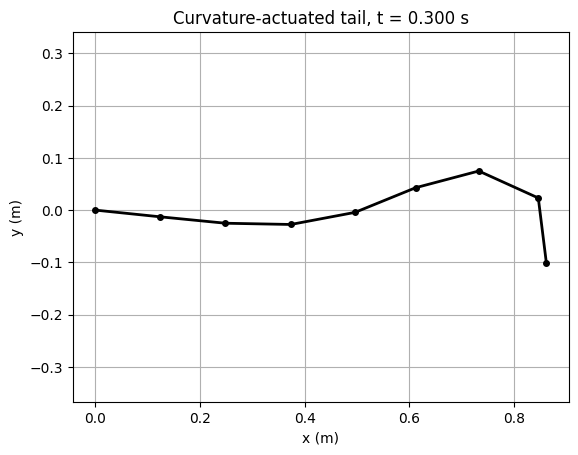

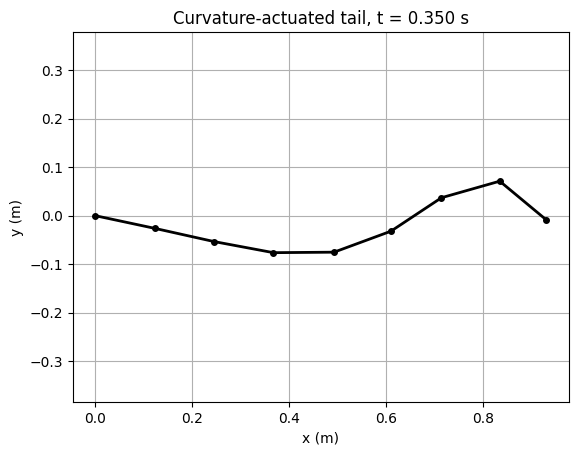

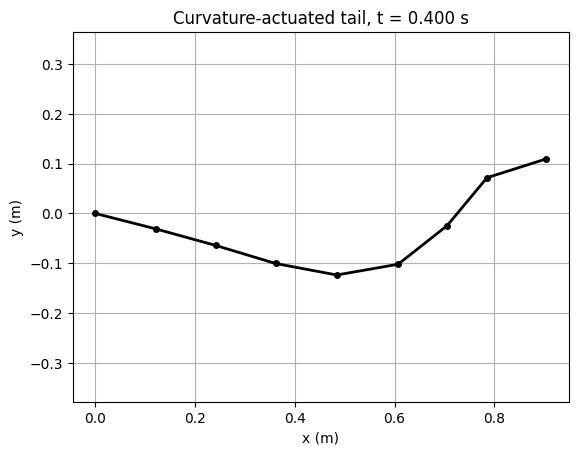

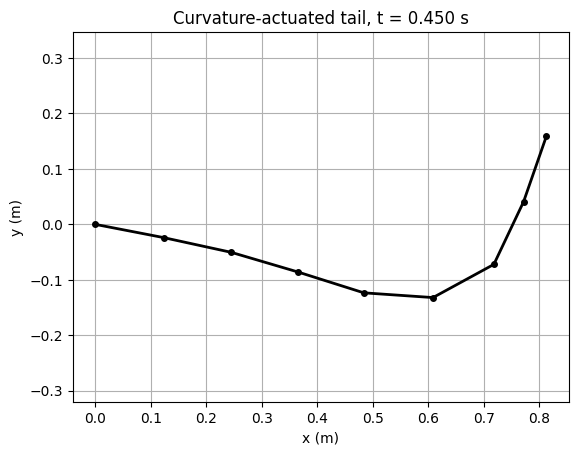

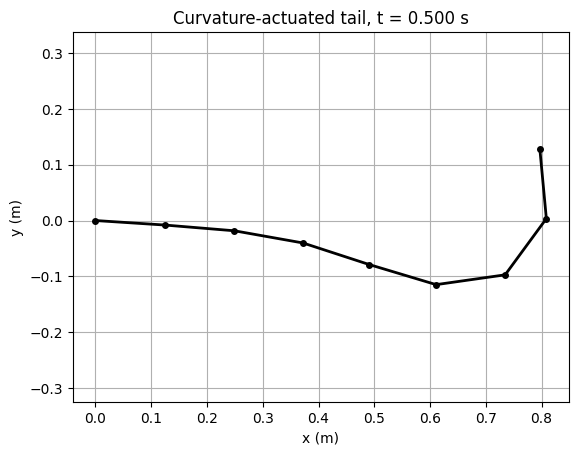

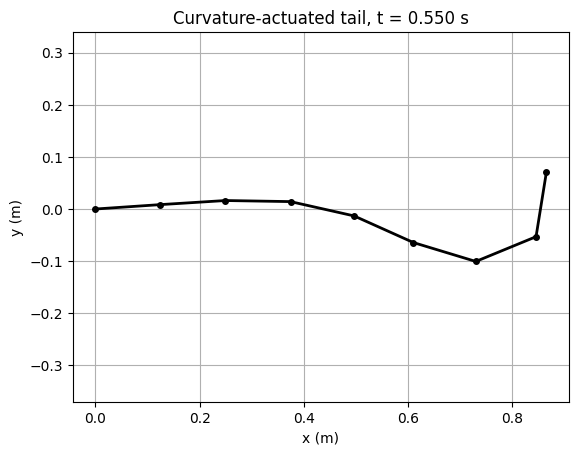

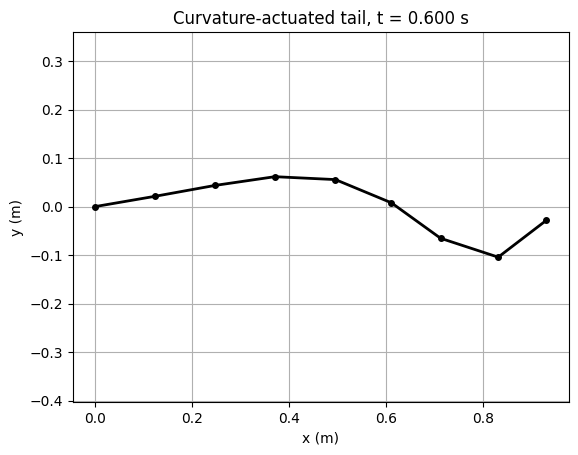

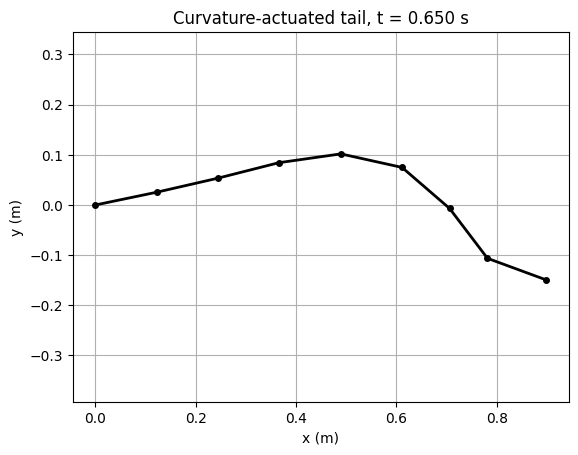

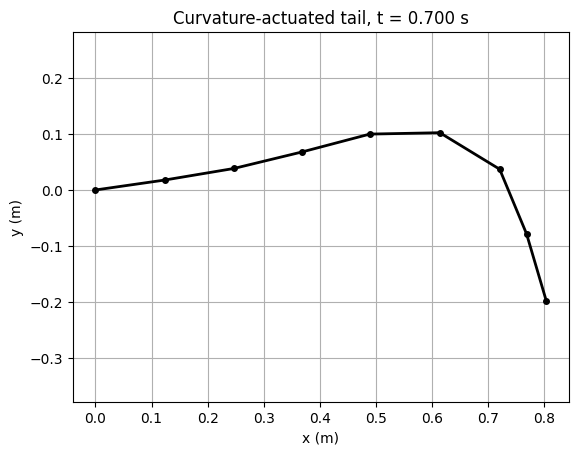

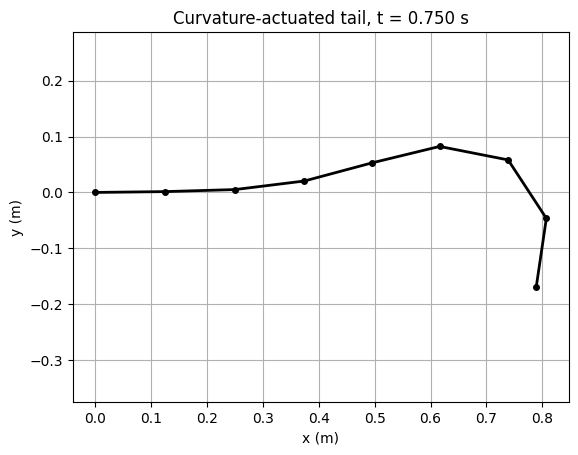

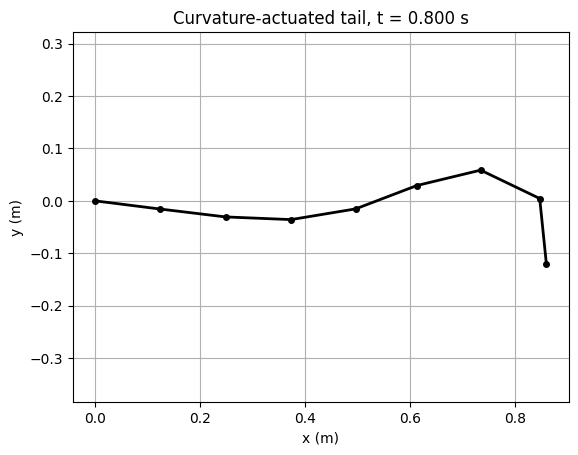

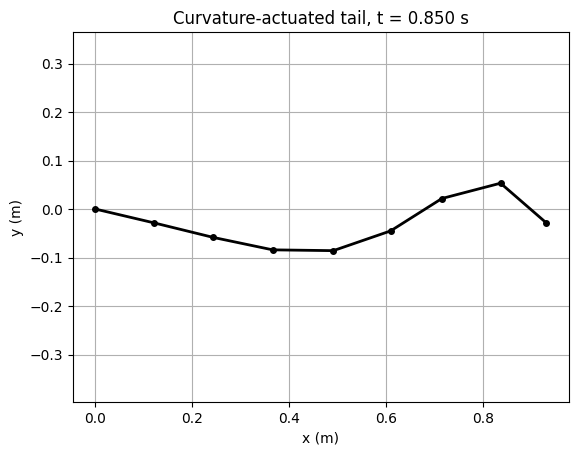

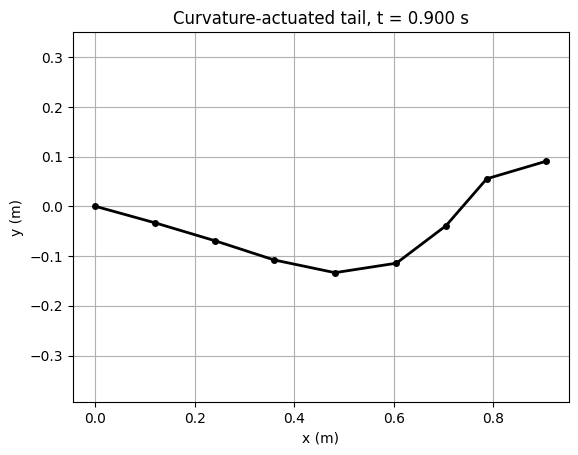

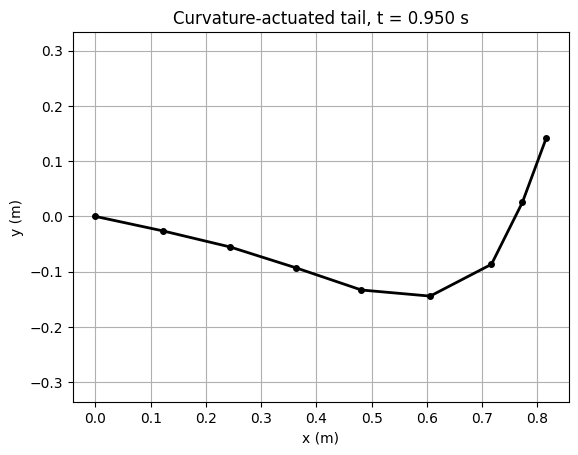

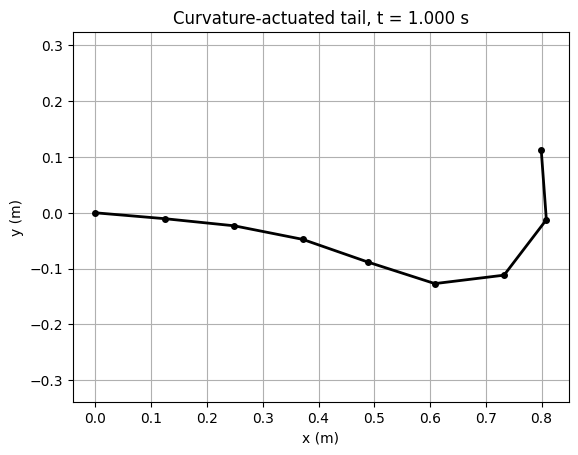

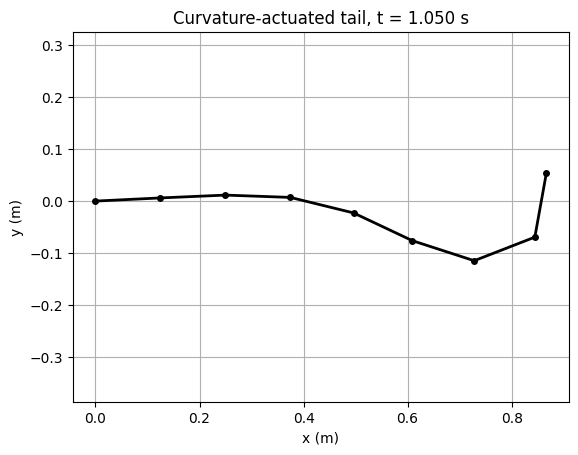

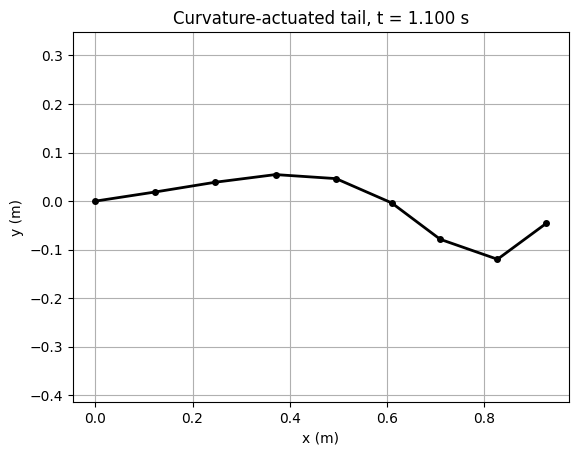

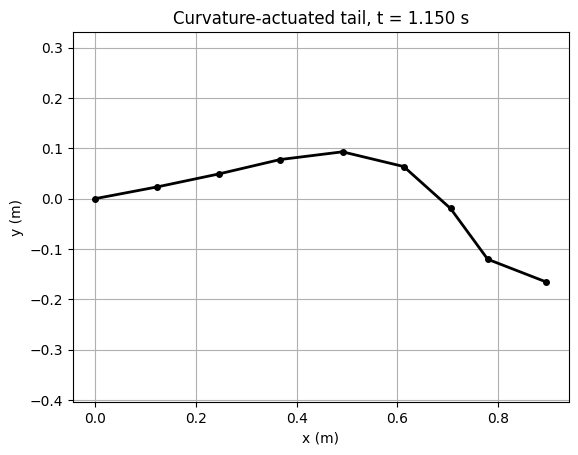

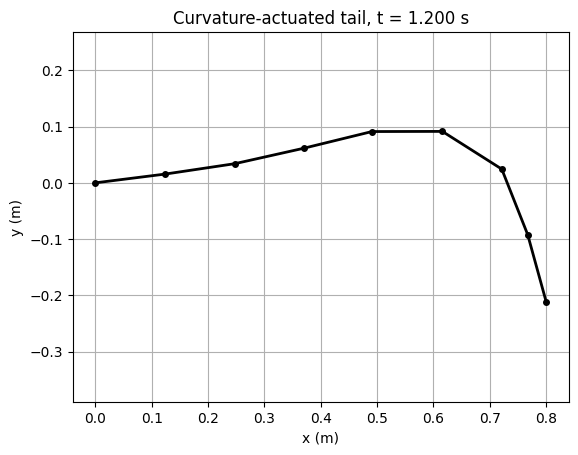

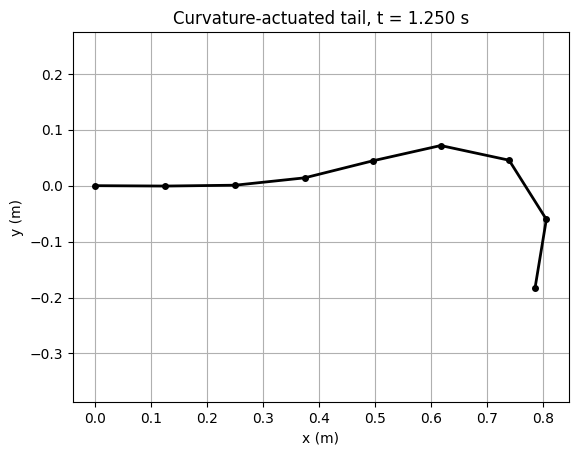

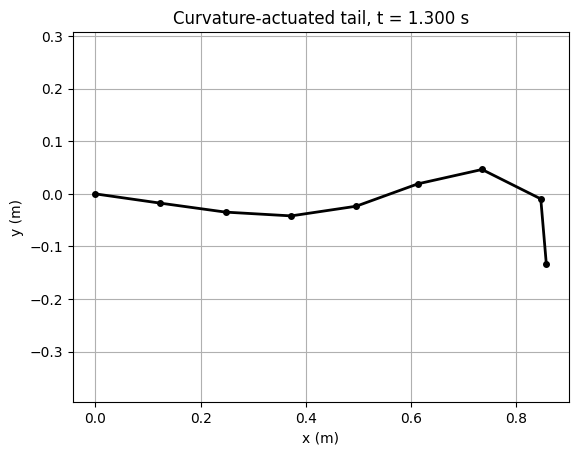

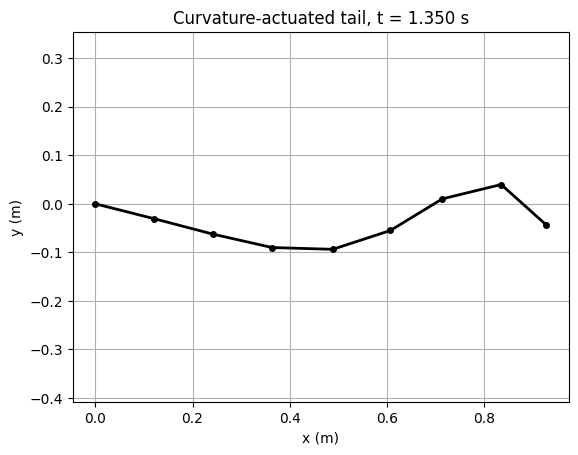

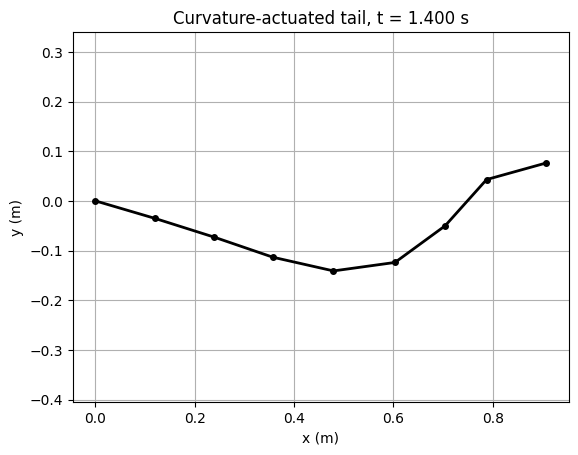

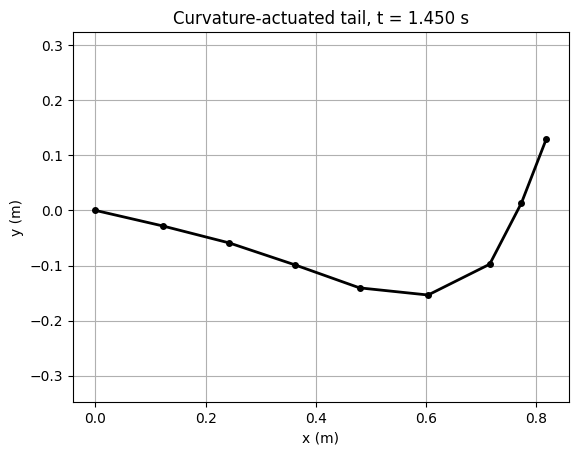

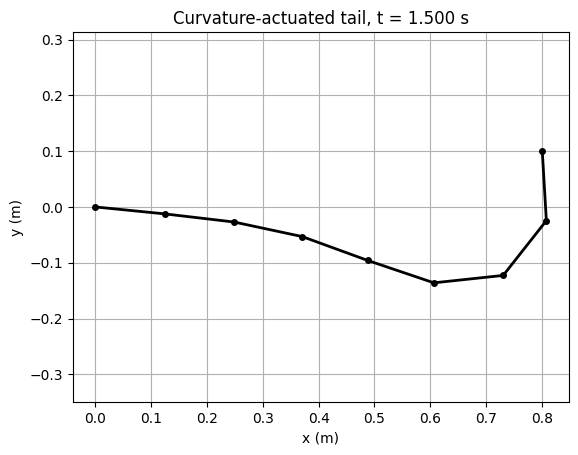

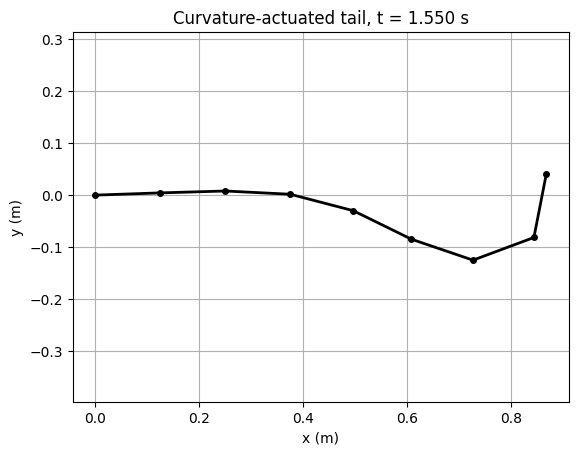

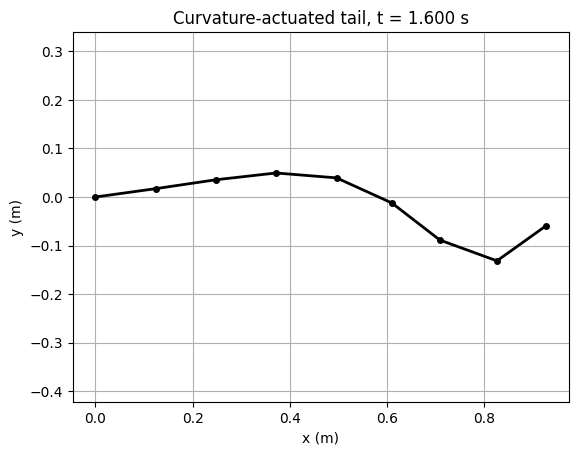

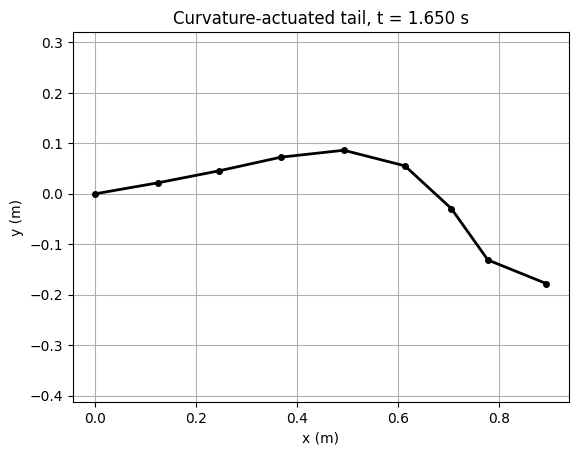

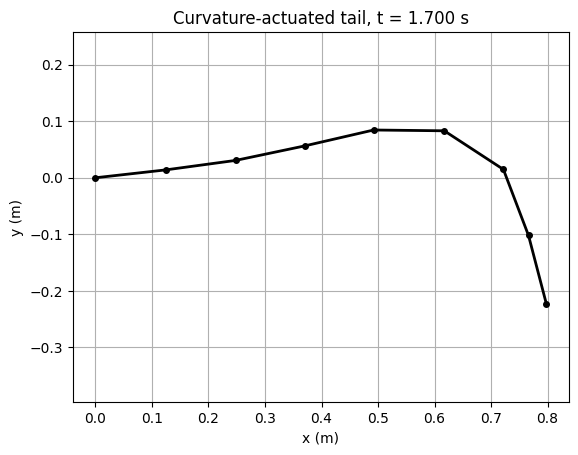

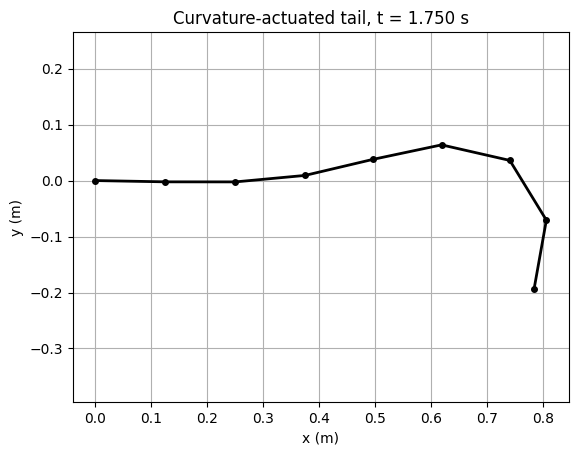

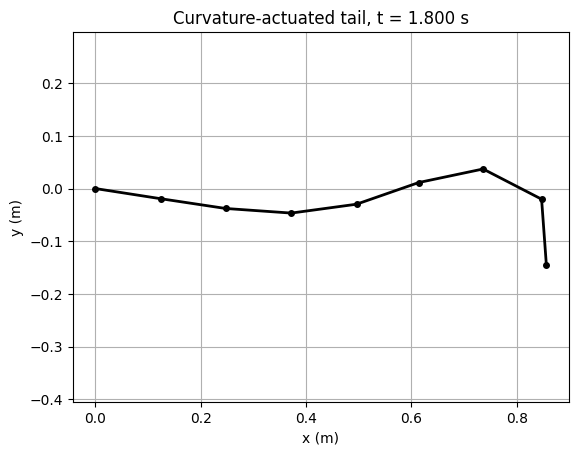

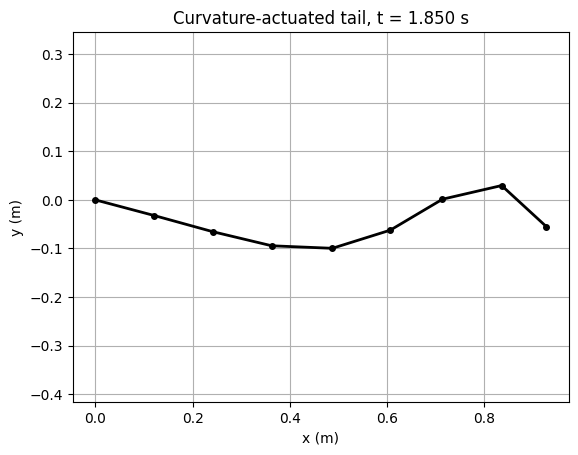

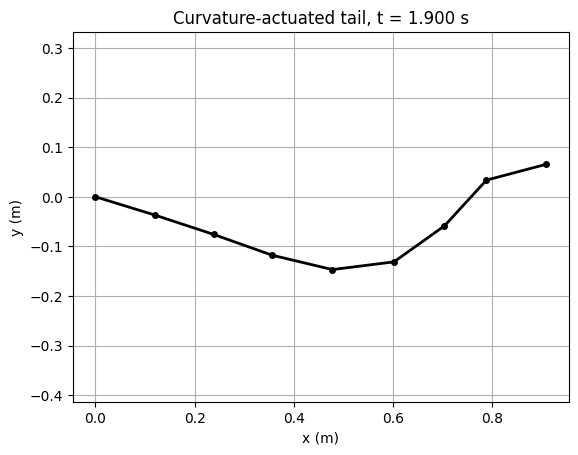

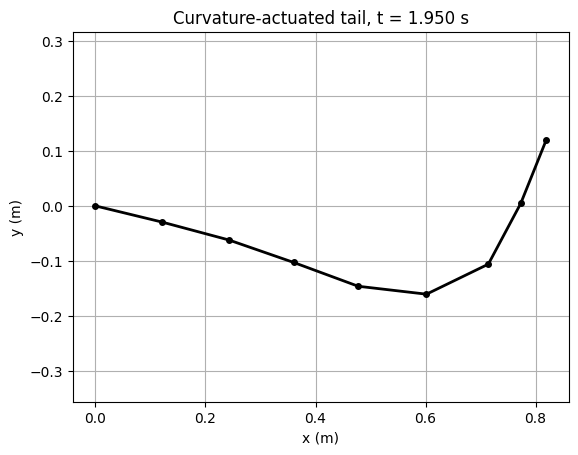

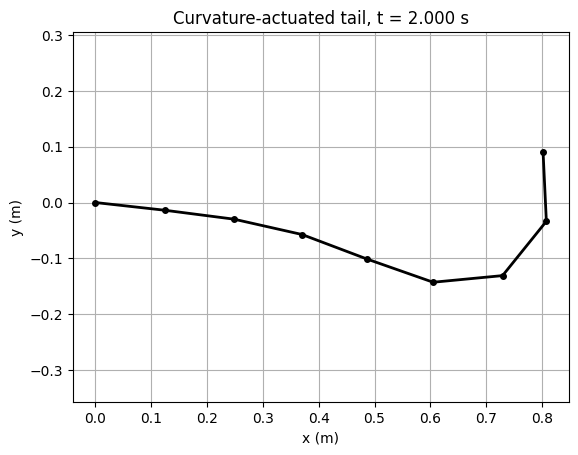

Simulation completed!


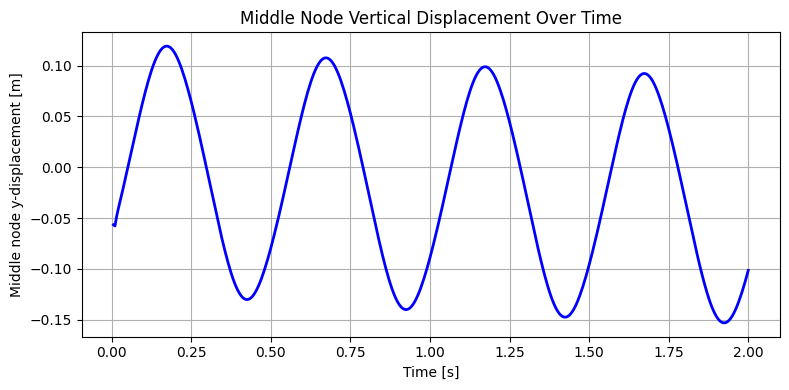

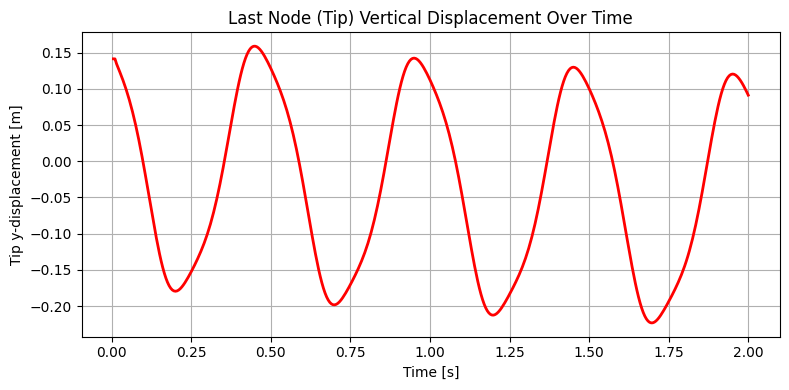

In [ ]:
# ============================================
# CURVATURE-DRIVEN TAIL SIMULATION
# ============================================

# Time and integration
dt = 0.005
totalTime = 2.0
Nsteps = int(totalTime / dt)
ctime = 0.0

# Viscous drag (low-Re style) – slightly higher for smoother motion
visc = 0.2
C = np.zeros((2 * nv, 2 * nv))
for k in range(nv):
    equiv_radius = np.sqrt(A/np.pi)
    C[2*k, 2*k]     = 6.0 * np.pi * visc * equiv_radius
    C[2*k+1, 2*k+1] = 6.0 * np.pi * visc * equiv_radius

# Disable gravity (neutrally buoyant tail in fluid)
W[:] = 0.0

# Curvature actuation parameters
kappa_amp = 1.5                     # [1/m] – gentle but visible; tune 1.0–2.0
f_act = 2.0                         # [Hz]
omega = 2.0 * np.pi * f_act
k_wave = 2.0 * np.pi / RodLength    # ~ one spatial wavelength

# Boundary conditions: clamp only the left end
ndof = 2 * nv
all_DOFs  = np.arange(ndof)
fixed_left = np.array([0, 1])       # x0, y0
free_index = np.setdiff1d(all_DOFs, fixed_left)

# Initial straight configuration
q0 = np.zeros(ndof)
for c in range(nv):
    q0[2*c]   = c * deltaL
    q0[2*c+1] = 0.0
u0 = np.zeros_like(q0)

# History for middle and tip motion
midNode = (nv + 1) // 2
time_hist  = []
mid_y_hist = []
tip_y_hist = []

print("Starting curvature-driven tail simulation...")

for step in range(1, Nsteps + 1):

    # Solve implicit step with curvature actuation at current time
    q_new, flag = objfun(q0, u0, dt, tol, maximum_iter,
                         m, mMat,
                         EI, EA,
                         W, C,
                         deltaL,
                         free_index,
                         ctime,
                         kappa_amp, omega, k_wave)

    if flag < 0:
        print(f"Convergence failed at step {step}, t = {ctime:.3f} s")
        break

    # Update velocity and time
    u_new = (q_new - q0) / dt
    ctime += dt

    # Store for next step
    q0 = q_new.copy()
    u0 = u_new.copy()

    # Record middle and tip vertical displacement
    y_mid = q_new[2*(midNode-1) + 1]
    y_tip = q_new[2*(nv-1) + 1]

    time_hist.append(ctime)
    mid_y_hist.append(y_mid)
    tip_y_hist.append(y_tip)

    # --- Animation every few steps ---
    if step == 1 or step % 10 == 0 or step == Nsteps:
        x_arr = q_new[0::2]
        y_arr = q_new[1::2]

        plt.figure(1)
        plt.clf()
        plt.plot(x_arr, y_arr, 'k-', linewidth=2, marker='o', markersize=4)
        plt.title(f'Curvature-actuated tail, t = {ctime:.3f} s')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.axis('equal')
        plt.grid(True)
        plt.pause(0.001)

print("Simulation completed!")

# ============================================
# MOVEMENT DIAGRAMS: MIDDLE NODE & TIP
# ============================================

time_hist  = np.array(time_hist)
mid_y_hist = np.array(mid_y_hist)
tip_y_hist = np.array(tip_y_hist)

# 1) Middle node y-displacement vs time
plt.figure(figsize=(8,4))
plt.plot(time_hist, mid_y_hist, 'b-', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Middle node y-displacement [m]")
plt.title("Middle Node Vertical Displacement Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Last node (tip) y-displacement vs time
plt.figure(figsize=(8,4))
plt.plot(time_hist, tip_y_hist, 'r-', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Tip y-displacement [m]")
plt.title("Last Node (Tip) Vertical Displacement Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

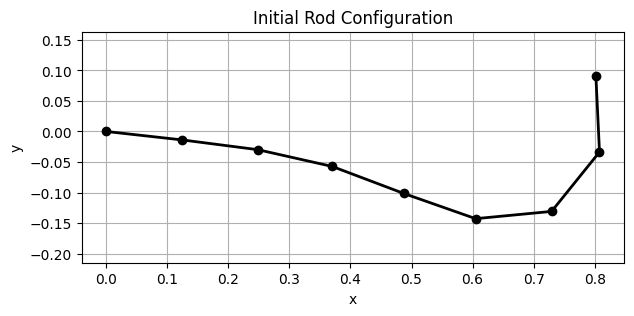

In [ ]:
# ============================================
# PLOT INITIAL ROD CONFIGURATION
# ============================================

# Extract x and y coordinates from q0
x_init = q0[0::2]
y_init = q0[1::2]

plt.figure(figsize=(7,3))
plt.plot(x_init, y_init, 'ko-', linewidth=2)
plt.title("Initial Rod Configuration")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.show()